#### Importing Libraries

In [1]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import time
from sortedcontainers import SortedSet # Used for fringe in A star
import queue
from collections import deque 

### ------------------------------------------------------------------------------------------------------------------------------

#### Grid and Cell class

In [2]:
# Class cell -> its the class of all the nodes in the grid, Each cell of the grid is defined as a object of type 
# cell.
class cell:
    def __init__(self,x,y): # Constructor for class cell
        self.x = x # x coordinate of the cell
        self.y = y # y coordinate of the cell
        self.g = 0 # g value of the cell (the distance from start cell to curr cell)
        self.h = 0 # h value of the cell (estimated value of the distance between curr cell and goal cell)
        self.f = 0 # f value of the cell (f = g+h in A*, defines the priority of a node)
        self.N_x = 0 # number of neighbors of cell x
        self.visited = False # whether the cell has been visited by the inference agent or not keep this info across all repeated A* calls
        self.C_x = -1 # number of neighbors sensed to be blocked
        self.B_x = 0 # number of neighbors confirmed to be blocked
        self.E_x = 0 # number of neighbors confirmed to be empty
        self.H_x = 0 # number of cells still hidden or unconfirmed
        self.blocked = False # Flag to indicate whether the cell is blocked or not
        self.neighbors_updated = False # used to prevent unnecessary information update in the agent
        self.prob = 0
        self.min_Hx = 8
        self.min_Hx_ind = ()
    
    def set_h_value(self, g_x, g_y, heuristic, weight):
        '''This function is used to assign the heuristic value i.e. the h value and the f value to the calling 
           class object. It takes in the argument g_x = goal cell abscissa, g_y = goal cell ordinate, 
           heuristic = It defines the type of heuristic the A* problem is using, weight = this is for problem 
           number 9 where we test the effect of weights on the performance of repeated A* and normal A*.'''
        if heuristic == 'm': 
            # Manhattan distance
            self.h = weight * abs(g_x - self.x) + abs(g_y - self.y)
            self.f = self.g + self.h + self.prob # also updating f inside this function
        if heuristic == 'e':
            # euclidean distance
            self.h = weight * math.sqrt((g_x - self.x)**2 + (g_y - self.y)**2)
            self.f = self.g + self.h + self.prob
        if heuristic == 'c':
            # chebyshev distance
            self.h = weight * max(abs(g_x - self.x), abs(g_y - self.y))
            self.f = self.g + self.h + self.prob
        if heuristic == 'dec_weight_m':
            # dec_weight_m manhattan distance is used as the heuristic
            # Adaptive weight technique, nodes nearer to the goal cell are assigned lower weight and nodes farther
            # away from the goal cell are assigned greater weights.
            self.h = abs(g_x - self.x) + abs(g_y - self.y)
            # if g < (2w-1)h then reduce the weight of g else reduce the weights of both g and h
            if self.g < (2*weight - 1) * self.h: 
                self.f = self.g / (2*weight - 1) + self.h
            else:
                self.f = (self.g + self.h) / weight 
        if heuristic == 'dec_weight_e':
            # dec_weight_e euclidean distance is used as the heuristic
            self.h = math.sqrt((g_x - self.x)**2 + (g_y - self.y)**2)
            # same exp as in dec_weight_m
            if self.g < (2*weight - 1) * self.h:
                self.f = self.g / (2*weight - 1) + self.h
            else:
                self.f = (self.g + self.h) / weight
        if heuristic == 'dec_weight_c':
            # chebyshev distance is used as the heuristic
            self.h = max(abs(g_x - self.x), abs(g_y - self.y))
            # same explanation as dec_weight_m
            if self.g < (2*weight - 1) * self.h:
                self.f = self.g / (2*weight - 1) + self.h
            else:
                self.f = (self.g + self.h) / weight
        if heuristic == 'inc_weight_m':
            # This is also an adaptive weight technique, but instead of decreasing weight as we move along the 
            # path, we assign more weight to h.
            self.h = abs(g_x - self.x) + abs(g_y - self.y)
            if self.g < self.h:
                self.f = self.g + self.h
            else:
                self.f = self.g + (2*weight-1)*self.h 
        if heuristic == 'g':
            # Toal greedy approach used in q4 to compare the speeds of A* and greedy best first search algorithm.
            # manhattan distance is used as heuristic
            self.h = abs(g_x - self.x) + abs(g_y - self.y)
            self.f = self.h

In [3]:
# Class grid_world -> This class is used to generate a grid world of dimension dim with each cell having 
# probability p of being blocked.
class grid_world:
    def __init__(self,p,dim):
        self.p = p # probability with which the cell is blocked
        self.dim = dim # dimension of the grid (dim x dim)
    def gen_grid(self,matrix):
        '''This function is used to generate the grid. The grid is returned in the form of list of list.'''
        for i in range(self.dim): # looping over the dimension to generate rows of cells
            a = [] # store a row of the grid of len dim
            for j in range(self.dim): # looping over the dim to generate cols of cells
                c = cell(i,j) # cell for coordinates (i,j)
                chance = random.uniform(0,1) 
                # generating a random number between 0 and 1 from uniform distribution, if its less than p 
                # the cell is blocked else the cell is unblocked.
                if i == 0 and j == 0: # [0,0] is the start cell location so don't want to block it, simply append
                    # and continue.
                    a.append(c)
                    continue
                if i == self.dim-1 and j == self.dim-1: #[dim-1, dim-1] is the goal cell location, so don't want to
                    # block it simply append and continue
                    a.append(c)
                    continue
                # if the number generated is less than or equal to p, block the cell.
                if(chance <= self.p):
                    c.blocked = True
                        
                a.append(c) # append the cell to the row
            matrix.append(a) # append the row to the grid
        return matrix # return the final grid

In [4]:
def gen_env(p, dim):
    '''Function to generate the enviornment with probability of blockage p and dimension = dim x dim'''
    temp = grid_world(p, dim)
    grid = temp.gen_grid([])
    return grid

In [5]:
def disp_grid(grid):
    '''Since our grid is a list of list of cells simply printing it does not work. This function prints the 
    grid with blockage as x and a cell on which we can travel as -'''
    l = []
    for i in range(len(grid)):
        a = []
        for j in range(len(grid)):
            if grid[i][j].blocked:
                a.append('x')
            else:
                a.append('-')
        l.append(a)
    return l

### -----------------------------------------------------------------------------------------------------------------------------

#### Astar

In [6]:
def Astar(grid,start_cell_ind,goal_cell_ind, heuristic, weight = 1):
    cells_processed = 0 # number of cells popped from the fringe before reaching the goal.
    number_of_clashes = 0 # number of time we had to update priorities in the fringe.
    start_cell = grid[start_cell_ind[0]][start_cell_ind[1]] # start cell of our grid.
    goal_cell = grid[goal_cell_ind[0]][goal_cell_ind[1]] # goal cell of our grid
    open_list = SortedSet() # fringe, we have used sorted set as our priority queue
    close_list = set() # contains cells already processed, have used set for this purpose (O(1) lookup on average)
    parent_dict = {} # stores parent child relationship, using dictionary for this
    visited = set() # child already visited, using set for this purpose (O(1) lookup on average)
    start_cell.g = 0 # Setting the g value of the start cell to 0
    # setting the h and f value of the start cell using the weight and heuristic passed in the function arguments.
    # weight is for q9
    start_cell.set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
    open_list.add((start_cell.f, start_cell.h, (start_cell.x, start_cell.y))) # adding the start cell to the priority queue
    # In the queue we are pushing a tuple whose first coordinate is the f value, second coordinate is the h value 
    # then a tuple containing the location of the cell. The priority is set according to the f value in case of a 
    # tie h value is seen.
    visited.add((start_cell.x, start_cell.y)) # updating the visited set as we are pushing the node in priority queue
    while len(open_list)>0: # loop over the priority queue until it is not empty or we reach the goal node
        cl = open_list.pop(0) # pop the node with the least priority (it is at index 0 in the sorted set)
        curr_cell = grid[cl[-1][0]][cl[-1][1]] # the last index in cl contains the x and y coordinates, 
        # storing the node popped from the queue in curr_cell.
        cells_processed += 1 # incrementing the number of cells processed (since we just popped from the queue)
        close_list.add((curr_cell.x, curr_cell.y)) # adding the node to the closed list as it is about to be processed
        if curr_cell == goal_cell: 
            # If the curr cell is the goal cell return the path from the curr cell to goal cell by backtracking 
            # from goal cell to curr cell using the parent dictionary as well as all the nodes 
            # that have been processed uptil now.
            path = []
            curr = curr_cell
            while (curr.x, curr.y) != (start_cell_ind[0], start_cell_ind[1]):
                path.append([curr.x, curr.y])
                curr = parent_dict[(curr.x, curr.y)]
            path.append([curr.x,curr.y])
            return path[::-1], cells_processed, number_of_clashes
        
        children = [] # This list is used to store all the possible valid children of the cell 
        # currently being processed.
        for new_pos in [(0,1),(0,-1),(1,0),(-1,0)]: # 4 main compass directions, field of view also the agent can 
            # only move to these locations
            node_pos = (curr_cell.x+new_pos[0], curr_cell.y+new_pos[1]) # position of the child
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                # if the child is not part of the grid continue
                continue
            if(grid[node_pos[0]][node_pos[1]].blocked):
                # if the child is blocked continue
                continue
            if((node_pos[0], node_pos[1]) in close_list):
                # if child is in close list continue
                continue
            if((node_pos[0], node_pos[1]) in visited):
                # if the child is already visited then compare the previous cost(f) to the new cost(f) and if the
                # new cost is lower update the priority of the child in the priority queue, update the 
                # parent dictionary and update the g value of the node.
                if curr_cell.g + 1 + grid[node_pos[0]][node_pos[1]].h + grid[node_pos[0]][node_pos[1]].prob < grid[node_pos[0]][node_pos[1]].f:
                    number_of_clashes += 1 # increment the number of clashes by 1
                    # To update the priority we remove the node from the sorted set (O(logn)) and reinsert with 
                    # new priority O(log(n)). 
                    open_list.remove((grid[node_pos[0]][node_pos[1]].f, grid[node_pos[0]][node_pos[1]].h, (grid[node_pos[0]][node_pos[1]].x, grid[node_pos[0]][node_pos[1]].y)))
                    grid[node_pos[0]][node_pos[1]].g = curr_cell.g+1
                    grid[node_pos[0]][node_pos[1]].set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
                    open_list.add((grid[node_pos[0]][node_pos[1]].f, grid[node_pos[0]][node_pos[1]].h, (grid[node_pos[0]][node_pos[1]].x, grid[node_pos[0]][node_pos[1]].y)))
                    parent_dict[(node_pos[0],node_pos[1])] = curr_cell # updating the parent dictionary
            else:
                # If the child is not visited update its g value, set its h and f value and add it to the 
                # children list after updating its parent.
                grid[node_pos[0]][node_pos[1]].g = curr_cell.g + 1
                grid[node_pos[0]][node_pos[1]].set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
                children.append(grid[node_pos[0]][node_pos[1]])
                parent_dict[(node_pos[0],node_pos[1])] = curr_cell
        if(children == []): # If no valid child continue
            continue
        for child in children: # else if valid children exist add them to the open list and update the visited set.
            open_list.add((child.f,child.h, (child.x, child.y)))
            visited.add((child.x, child.y))
    
    return [], 0, 0

### ------------------------------------------------------------------------------------------------------------------------------

#### Explore path function

In [7]:
# function to explore the path returned by A* algorithm. Update the bot_env and final_discovered_grid_world 
def explore_path(path,bot_env ,grid, final_discovered_grid_world):
    '''This functions helps move the agent along the path returned by A*. We update the bot enviornment and final 
    discovered grid world as the agent moves along the path. This function returns when the agent encounters a block 
    along the path or reaches the goal.'''
    # path is a list of list -> [[0,0], [0,2]......]
    for i in range(len(path)): # looping over the path list
        x = path[i][0] # x coordinate of the cell in the path 
        y = path[i][1] # y coordinate of the cell in the path
        # updating the information in the bot_env of the curr_cell
        bot_env[x][y].x = grid[x][y].x
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        # updating the information in the final discovered grid world of the curr_cell
        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        
        if(grid[x][y].blocked): # if we encounter the blocked cell return the path till the last unblocked cell
            return path[:i]
        #this function is assumed that the agent has 4 main directions of a compass as field of view
        for new_pos in [(0,1),(0,-1),(1,0),(-1,0)]: # In this loop we are updating the information in the bot_env
            # and final_discovered_gridworld for all the valid children of curr cell.
            node_pos = (x+new_pos[0], y+new_pos[1])#position of the child
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                # if the child is not part of the grid continue
                continue
            # update information for the child in bot_env and final discovered grid world.
            bot_env[node_pos[0]][node_pos[1]].x = grid[node_pos[0]][node_pos[1]].x
            bot_env[node_pos[0]][node_pos[1]].y = grid[node_pos[0]][node_pos[1]].y
            bot_env[node_pos[0]][node_pos[1]].blocked = grid[node_pos[0]][node_pos[1]].blocked
            final_discovered_grid_world[node_pos[0]][node_pos[1]].x = grid[node_pos[0]][node_pos[1]].x
            final_discovered_grid_world[node_pos[0]][node_pos[1]].y = grid[node_pos[0]][node_pos[1]].y
            final_discovered_grid_world[node_pos[0]][node_pos[1]].blocked = grid[node_pos[0]][node_pos[1]].blocked
    return path

In [8]:
#function to explore path returned by A* algorithm with limited field of view (the bot can only see in the direction of its movement along the path). 
def explore_path_with_limited_view(path,bot_env ,grid, final_discovered_grid_world):
    '''
    This function helps move the agent along the path returned by A* with unidirectional field of view. The bot environment
    and final discovered grid world are updated with status of cells along the path traversed.
    '''
    for i in range(len(path)): #looping over path list
        x = path[i][0] # x coordinate of the current node
        y = path[i][1] # y coordinate of the current node
        
        #update the bot environment and final discovered grid 
        bot_env[x][y].x = grid[x][y].x 
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        
        if(grid[x][y].blocked): #if the current node is blocked node, return the path traversed till now.
            return path[:i]
    
    return path

## -------------------------------------------------------------------------------------------------------

#### Agent 3

In [9]:
# function to explore the path returned by A* algorithm. Update the bot_env and final_discovered_grid_world 
def explore_path_new_agent(path,bot_env ,grid, final_discovered_grid_world, bumps):
    '''This functions helps move the agent along the path returned by A*. We update the bot enviornment and final 
    discovered grid world as the agent moves along the path. This function returns when the agent encounters a block 
    along the path or reaches the goal.'''
        
    def update_neighbors(x, y, q, nodes_in_queue):
        
        if(final_discovered_grid_world[x][y].neighbors_updated == False):
            
            for new_pos in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]:
                node_pos = (x+new_pos[0], y+new_pos[1])
                if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                    continue

                if(final_discovered_grid_world[x][y].blocked):
                    final_discovered_grid_world[node_pos[0]][node_pos[1]].B_x += 1
                    final_discovered_grid_world[node_pos[0]][node_pos[1]].H_x -= 1
                    bot_env[node_pos[0]][node_pos[1]].B_x += 1
                    bot_env[node_pos[0]][node_pos[1]].H_x -= 1

                else:
                    final_discovered_grid_world[node_pos[0]][node_pos[1]].E_x += 1
                    final_discovered_grid_world[node_pos[0]][node_pos[1]].H_x -= 1
                    bot_env[node_pos[0]][node_pos[1]].E_x += 1
                    bot_env[node_pos[0]][node_pos[1]].H_x -= 1
                    
                if((node_pos[0], node_pos[1]) not in nodes_in_queue):
                    q.put(node_pos)
                    nodes_in_queue.add((node_pos[0], node_pos[1]))
                    
            final_discovered_grid_world[x][y].neighbors_updated = True
            bot_env[x][y].neighbors_updated = True
        return q, nodes_in_queue
    
    # path is a list of list -> [[0,0], [0,2]......]
    for i in range(len(path)): # looping over the path list
        x = path[i][0] # x coordinate of the cell in the path 
        y = path[i][1] # y coordinate of the cell in the path
        # updating the information in the bot_env of the curr_cell
        bot_env[x][y].x = grid[x][y].x
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        # updating the information in the final discovered grid world of the curr_cell
        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        
        # If visiting for the first time sense neighbors and mark visited
        num_of_child = 0
        c_x = 0
        if(final_discovered_grid_world[x][y].visited == False):
            for new_pos in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]: 
                node_pos = (x+new_pos[0], y+new_pos[1])
                if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                    continue
                num_of_child += 1
                if(final_discovered_grid_world[x][y].blocked == False):
                    if(grid[node_pos[0]][node_pos[1]].blocked):
                        c_x += 1
        
            # Update N_x, C_x, H_x and mark visited
            bot_env[x][y].N_x = num_of_child
            if(bot_env[x][y].blocked == False):
                bot_env[x][y].C_x = c_x
            bot_env[x][y].visited = True
            bot_env[x][y].H_x += num_of_child

            final_discovered_grid_world[x][y].N_x = num_of_child
            if(final_discovered_grid_world[x][y].blocked == False):
                final_discovered_grid_world[x][y].C_x = c_x
            final_discovered_grid_world[x][y].visited = True
            final_discovered_grid_world[x][y].H_x += num_of_child
        
        q = queue.Queue()
        q.put((x,y))
        nodes_in_queue = set()
        nodes_in_queue.add((x,y))
        
        if final_discovered_grid_world[x][y].C_x == -1:
            q, nodes_in_queue = update_neighbors(x,y,q, nodes_in_queue)
        
        while(not q.empty()):
            pos = q.get()
            nodes_in_queue.remove((pos[0], pos[1]))
            if (final_discovered_grid_world[pos[0]][pos[1]].C_x == -1):
                continue
            q, nodes_in_queue = update_neighbors(pos[0],pos[1],q, nodes_in_queue)
            nodes_infered = knowledge_base(final_discovered_grid_world,bot_env,pos)
            if len(nodes_infered) == 0:
                continue
            else:
                for node in nodes_infered:
                    if node in nodes_in_queue:
                        continue
                    else:
                        nodes_in_queue.add(node)
                        q.put(node)
                        q, nodes_in_queue = update_neighbors(node[0], node[1], q, nodes_in_queue)
        
        
        if(grid[x][y].blocked): # if we encounter the blocked cell return the path till the last unblocked cell
            bumps += 1
            return (path[:i], bumps)
        else:
            infered_block = False
            for j in range(i+1,len(path)):
                if bot_env[path[j][0]][path[j][1]].blocked:
                    infered_block = True
                    break
                        
            if(infered_block == True):
                return (path[:i+1], bumps)
    return (path, bumps)

In [10]:
def knowledge_base(final_discovered_grid_world, bot_env, node_pos):
    
    list_of_nodes_infered = set()
    x = node_pos[0]
    y = node_pos[1]
    
    if (final_discovered_grid_world[x][y].H_x == 0):
        return list_of_nodes_infered
    
    if (final_discovered_grid_world[x][y].C_x == final_discovered_grid_world[x][y].B_x):
        for new_pos in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]:
            node_pos = (x+new_pos[0], y+new_pos[1])
            if(node_pos[0] > len(bot_env)-1 or node_pos[1] > len(bot_env)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                continue
            else:
                if(bot_env[node_pos[0]][node_pos[1]].blocked):
                    continue
                if(final_discovered_grid_world[node_pos[0]][node_pos[1]].visited == True):
                    continue
                if(final_discovered_grid_world[node_pos[0]][node_pos[1]].neighbors_updated == True):
                    continue
                final_discovered_grid_world[node_pos[0]][node_pos[1]].blocked = False
                list_of_nodes_infered.add((node_pos[0], node_pos[1]))
        return list_of_nodes_infered
    if (final_discovered_grid_world[x][y].N_x - final_discovered_grid_world[x][y].C_x == final_discovered_grid_world[x][y].E_x):
        for new_pos in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]:
            node_pos = (x+new_pos[0], y+new_pos[1])
            if(node_pos[0] > len(bot_env)-1 or node_pos[1] > len(bot_env)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                continue
            else:
                if(final_discovered_grid_world[node_pos[0]][node_pos[1]].blocked == False):
                    continue
                if(bot_env[node_pos[0]][node_pos[1]].visited == True):
                    continue
                if(bot_env[node_pos[0]][node_pos[1]].neighbors_updated == True):
                    continue
                bot_env[node_pos[0]][node_pos[1]].blocked = True
                list_of_nodes_infered.add((node_pos[0], node_pos[1]))
        return list_of_nodes_infered
    return list_of_nodes_infered

## -------------------------------------------------------------------------------------------------------

#### Agent 4

In [11]:
# kb should be an empty set during the first call out.
def explore_path_new_agent_4(path,bot_env ,grid, final_discovered_grid_world, bumps, kb):
    for i in range(len(path)): # looping over the path list
        # Mark in final discovered and bot_env if the cell is blocked or unblocked also mark visited.
        
        x = path[i][0] # x coordinate of the cell in the path 
        y = path[i][1] # y coordinate of the cell in the path

        bot_env[x][y].x = grid[x][y].x
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked

        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        
        if(final_discovered_grid_world[x][y].visited == True):
            continue
            
        final_discovered_grid_world[x][y].visited = True
        bot_env[x][y].visited = True
        # Calculate the C_x for the cell.
        
        c_x = 0
        eqn_neighbors = [set(),0]
        for new_pos in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]: 
            node_pos = (x+new_pos[0], y+new_pos[1])
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                continue

            eqn_neighbors[0].add((node_pos[0], node_pos[1]))

            if(grid[node_pos[0]][node_pos[1]].blocked):
                eqn_neighbors[1] += 1
                c_x += 1
        
        final_discovered_grid_world[x][y].C_x = c_x
        bot_env[x][y].C_x = c_x
        
        
        
        eqn = [set(),0]
        eqn[0].add((x,y))
        if(grid[x][y].blocked):
            eqn[1] += 1
        
        q = deque()
        q.append(eqn.copy())

        if(eqn_neighbors[1] == 0):
            for tup in eqn_neighbors[0]:
                t = [{tup}, 0]
                q.append(t.copy())
        elif(len(eqn_neighbors[0]) == eqn_neighbors[1]):
            for tup in eqn_neighbors[0]:
                t = [{tup}, 1]
                q.append(t.copy())
        else:
            q.append(eqn_neighbors.copy())
        
        while(len(q)):
            eqn_popped_from_q = q.popleft()
            if(len(eqn_popped_from_q[0]) == 1):
                ind = next(iter(eqn_popped_from_q[0]))
                if(eqn_popped_from_q[1] == 0):
                    final_discovered_grid_world[ind[0]][ind[1]].blocked = False
                else:
                    bot_env[ind[0]][ind[1]].blocked = True
            else:
                temp_eqn = eqn_popped_from_q[0].copy()
                for node_pos in eqn_popped_from_q[0]:
                    if(final_discovered_grid_world[node_pos[0]][node_pos[1]].blocked == False): 
                        temp_eqn.remove(node_pos)
                    elif(bot_env[node_pos[0]][node_pos[1]].blocked == True):
                        temp_eqn.remove(node_pos)
                        eqn_popped_from_q[1] -= 1
                
                eqn_popped_from_q[0] = temp_eqn
                if(len(eqn_popped_from_q[0]) == 0):
                    continue
                if(eqn_popped_from_q[1] == 0):
                    for tup in eqn_popped_from_q[0]:
                        tup1 = [{tup}, 0]
                        q.appendleft(tup1)
                    continue
                elif(eqn_popped_from_q[1] == len(eqn_popped_from_q[0])):
                    for tup in eqn_popped_from_q[0]:
                        tup1 = [{tup}, 1]
                        q.appendleft(tup1)
                    continue 
            if(eqn_popped_from_q in kb):
                continue
            
            q, sub_seq_flag = knowledge_base_agent_4_subsequence(final_discovered_grid_world, bot_env, eqn_popped_from_q, kb, q)
            q, set_diff_flag = knowledge_base_agent_4_set_diff(final_discovered_grid_world, bot_env, eqn_popped_from_q, kb, q)
            
            if(sub_seq_flag or set_diff_flag):
                continue
            else:
                if(len(eqn_popped_from_q[0]) == 1):
                    continue
                kb.append(eqn_popped_from_q)
        
        if(grid[x][y].blocked):
            bumps += 1
            return (path[:i], bumps, kb)
        else:
            infered_block = False
            for j in range(i+1,len(path)):
                if bot_env[path[j][0]][path[j][1]].blocked:
                    infered_block = True
                    break
                        
            if(infered_block == True):
                return (path[:i+1], bumps, kb)
    return (path, bumps, kb)

In [12]:
def knowledge_base_agent_4_subsequence(final_discovered_grid_world, bot_env, eqn, kb, q):
    sub_seq_flag = False
    for kb_eqn in kb:
        if (len(kb_eqn[0]) >= len(eqn[0])):
            if (eqn[0].issubset(kb_eqn[0]) == True):
                kb.remove(kb_eqn)
                kb_eqn[0] = kb_eqn[0].difference(eqn[0])
                kb_eqn[1] = kb_eqn[1] - eqn[1]
                if(len(kb_eqn[0]) == kb_eqn[1]):
                    for i in kb_eqn[0]:
                        t = [{i}, 1]
                        q.appendleft(t)
                elif(kb_eqn[1] == 0):
                    for i in kb_eqn[0]:
                        t = [{i}, 0]
                        q.appendleft(t)
                else:
                    q.append(kb_eqn)
        else:
            temp = eqn
            if (kb_eqn[0].issubset(temp[0]) == True):
                temp[0] = temp[0].difference(kb_eqn[0])
                temp[1] = temp[1] - kb_eqn[1]
                sub_seq_flag = True
                if(len(temp[0]) == temp[1]):
                    for i in temp[0]:
                        t = [{i}, 1]
                        q.appendleft(t)
                elif(len(temp[0]) == 0):
                    for i in temp[0]:
                        t = [{i}, 0]
                        q.appendleft(t)
                else:
                    q.appendleft(temp)
    return q, sub_seq_flag                

In [13]:
def knowledge_base_agent_4_set_diff(final_discovered_grid_world, bot_env, eqn, kb, q):
    set_diff_flag = False
    for kb_eqn in kb:
        if kb_eqn[1] >= eqn[1]:
            sd = kb_eqn[0].difference(eqn[0])
            if(len(sd) == 0):
                continue
            if(len(sd) == kb_eqn[1]-eqn[1]):
                set_diff_flag = True
                for i in sd:
                    t = [{i}, 1]
                    q.appendleft(t)
                for i in eqn[0].difference(kb_eqn[0]):
                    t = [{i}, 0]
                    q.appendleft(t)
        else:
            sd = eqn[0].difference(kb_eqn[0])
            if(len(sd) == 0):
                continue
            if(len(sd) == eqn[1] - kb_eqn[1]):
                set_diff_flag = True
                for i in sd:
                    t = [{i}, 1]
                    q.appendleft(t)
                for i in kb_eqn[0].difference(eqn[0]):
                    t = [{i}, 0]
                    q.appendleft(t)
                    
    return q, set_diff_flag

### -----------------------------------------------------------------------------------------------------------------------------

#### Agent 5

In [14]:
# kb should be an empty set during the first call out.
def explore_path_new_agent_5(path,bot_env ,grid, final_discovered_grid_world, bumps, kb):
    def update_neighbors(x, y):
        if(final_discovered_grid_world[x][y].neighbors_updated == False):
            
            for new_pos in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]:
                node_pos = (x+new_pos[0], y+new_pos[1])
                if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                    continue

                if(final_discovered_grid_world[x][y].blocked):
                    final_discovered_grid_world[node_pos[0]][node_pos[1]].B_x += 1
                    final_discovered_grid_world[node_pos[0]][node_pos[1]].H_x -= 1
                    bot_env[node_pos[0]][node_pos[1]].B_x += 1
                    bot_env[node_pos[0]][node_pos[1]].H_x -= 1
                    if(final_discovered_grid_world[node_pos[0]][node_pos[1]].visited):
                        update_neighbors_prob(node_pos[0], node_pos[1])
                else:
                    final_discovered_grid_world[node_pos[0]][node_pos[1]].E_x += 1
                    final_discovered_grid_world[node_pos[0]][node_pos[1]].H_x -= 1
                    bot_env[node_pos[0]][node_pos[1]].E_x += 1
                    bot_env[node_pos[0]][node_pos[1]].H_x -= 1
                    if(final_discovered_grid_world[node_pos[0]][node_pos[1]].visited):
                        update_neighbors_prob(node_pos[0], node_pos[1])
                    
            final_discovered_grid_world[x][y].neighbors_updated = True
            bot_env[x][y].neighbors_updated = True
    
    def update_neighbors_prob(x,y):
        for new_pos in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]:
                
            node_pos = (x+new_pos[0], y+new_pos[1])
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                continue
                
            if(final_discovered_grid_world[node_pos[0]][node_pos[1]].blocked == False or bot_env[node_pos[0]][node_pos[1]].blocked == True):
                continue
               
            new_hx = final_discovered_grid_world[x][y].H_x
            old_hx = final_discovered_grid_world[node_pos[0]][node_pos[1]].min_Hx
            
            if new_hx < old_hx:
                c_x = final_discovered_grid_world[x][y].C_x
                b_x = final_discovered_grid_world[x][y].B_x
                final_discovered_grid_world[node_pos[0]][node_pos[1]].min_Hx = new_hx
                final_discovered_grid_world[node_pos[0]][node_pos[1]].prob = (c_x - b_x)/new_hx
                final_discovered_grid_world[node_pos[0]][node_pos[1]].min_Hx_ind = (x,y)
                bot_env[node_pos[0]][node_pos[1]].min_Hx = new_hx
                bot_env[node_pos[0]][node_pos[1]].prob = (c_x - b_x)/new_hx
                bot_env[node_pos[0]][node_pos[1]].min_Hx_ind = (x,y)
            else:
                continue
    
    for i in range(len(path)): # looping over the path list
        # Mark in final discovered and bot_env if the cell is blocked or unblocked also mark visited.
        
        x = path[i][0] # x coordinate of the cell in the path 
        y = path[i][1] # y coordinate of the cell in the path

        bot_env[x][y].x = grid[x][y].x
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked

        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        
        if(final_discovered_grid_world[x][y].visited == True):
            continue
        
        update_neighbors(x,y)
            
        final_discovered_grid_world[x][y].visited = True
        bot_env[x][y].visited = True
        # Calculate the C_x for the cell.
        
        c_x = 0
        num_of_childs = 0
        eqn_neighbors = [set(),0]
        for new_pos in [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]: 
            node_pos = (x+new_pos[0], y+new_pos[1])
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                continue
            
            num_of_childs += 1
            eqn_neighbors[0].add((node_pos[0], node_pos[1]))

            if(grid[node_pos[0]][node_pos[1]].blocked):
                eqn_neighbors[1] += 1
                c_x += 1
        
        final_discovered_grid_world[x][y].C_x = c_x
        bot_env[x][y].C_x = c_x
        final_discovered_grid_world[x][y].N_x = num_of_childs
        final_discovered_grid_world[x][y].H_x += num_of_childs
        if (final_discovered_grid_world[x][y].blocked == True):
            final_discovered_grid_world[x][y].prob = 1
            bot_env[x][y].prob = 1
            update_neighbors_prob(x,y)
        else:
            final_discovered_grid_world[x][y].prob = 0
            bot_env[x][y].prob = 0
            update_neighbors_prob(x,y)
        
        
        eqn = [set(),0]
        eqn[0].add((x,y))
        if(grid[x][y].blocked):
            eqn[1] += 1
        
        q = deque()
        q.append(eqn.copy())

        if(eqn_neighbors[1] == 0):
            for tup in eqn_neighbors[0]:
                t = [{tup}, 0]
                q.append(t.copy())
        elif(len(eqn_neighbors[0]) == eqn_neighbors[1]):
            for tup in eqn_neighbors[0]:
                t = [{tup}, 1]
                q.append(t.copy())
        else:
            q.append(eqn_neighbors.copy())
        
        while(len(q)):
            eqn_popped_from_q = q.popleft()
            if(len(eqn_popped_from_q[0]) == 1):
                ind = next(iter(eqn_popped_from_q[0]))
                if(eqn_popped_from_q[1] == 0):
                    final_discovered_grid_world[ind[0]][ind[1]].blocked = False
                    final_discovered_grid_world[ind[0]][ind[1]].prob = 0
                    bot_env[ind[0]][ind[1]].prob = 0
                    update_neighbors(ind[0], ind[1])
                else:
                    bot_env[ind[0]][ind[1]].blocked = True
                    final_discovered_grid_world[ind[0]][ind[1]].prob = 1
                    bot_env[ind[0]][ind[1]].prob = 1
                    update_neighbors(ind[0], ind[1])
                    
            else: 
                temp_eqn = eqn_popped_from_q[0].copy()
                for node_pos in eqn_popped_from_q[0]:
                    if(final_discovered_grid_world[node_pos[0]][node_pos[1]].blocked == False): 
                        temp_eqn.remove(node_pos)
                    elif(bot_env[node_pos[0]][node_pos[1]].blocked == True):
                        temp_eqn.remove(node_pos)
                        eqn_popped_from_q[1] -= 1
                
                eqn_popped_from_q[0] = temp_eqn
                if(len(eqn_popped_from_q[0]) == 0):
                    continue
                if(eqn_popped_from_q[1] == 0):
                    for tup in eqn_popped_from_q[0]:
                        tup1 = [{tup}, 0]
                        q.appendleft(tup1)
                    continue
                elif(eqn_popped_from_q[1] == len(eqn_popped_from_q[0])):
                    for tup in eqn_popped_from_q[0]:
                        tup1 = [{tup}, 1]
                        q.appendleft(tup1)
                    continue 
            if(eqn_popped_from_q in kb):
                continue
            
            q, sub_seq_flag = knowledge_base_agent_4_subsequence(final_discovered_grid_world, bot_env, eqn_popped_from_q, kb, q)
            q, set_diff_flag = knowledge_base_agent_4_set_diff(final_discovered_grid_world, bot_env, eqn_popped_from_q, kb, q)
            
            if(sub_seq_flag or set_diff_flag):
                continue
            else:
                if(len(eqn_popped_from_q[0]) == 1):
                    continue
                kb.append(eqn_popped_from_q)
        
        if(grid[x][y].blocked):
            bumps += 1
            return (path[:i], bumps, kb)
        else:
            infered_block = False
            for j in range(i+1,len(path)):
                if bot_env[path[j][0]][path[j][1]].blocked:
                    infered_block = True
                    break
                        
            if(infered_block == True):
                return (path[:i+1], bumps, kb)
    return (path, bumps, kb)

#### Repeated A*

In [15]:
# function to implement the A* algorithm
def repeated_astar(bot_env, real_world_grid, start_cell_ind, goal_cell_ind, heuristic, final_discovered_grid_world, limited_view = False, weight=1, inf_bot = False):
    '''
    This function is the implementation of the repeated A* algorithm. This function calls A* algorithm whenver a 
    blocked cell is encountered along the path returned by A*.
    '''
    count = 0
    bumps = 0
    paths = [] # stores the path to be returned.
    cp = 0  # keeps count of the total number of cells processed in each A* call.
    #while the A* algorithm doesn't return a path or the maze is found to be not solvable 
    
    kb = []
    
    planning_time = 0
    nodes_disc = 0
    while(1):
        count += 1
        t = time.time()
        path, cells_processed, n_c = Astar(bot_env, start_cell_ind, goal_cell_ind, heuristic, weight) # call A* with current knowledge of the grid
        planning_time += time.time() - t
        cp += cells_processed # add the number of cells processed to the variable cp which keeps the total number of cells processed for each iteration of A*
        if(path == []): # If A* doesn't return a path, path doesn't exist. Break from the loop and print "Maze is not solvable"
            print("Maze is not solveable")
            break
        else:  # If path exists, do this:
            if not limited_view:
                if not inf_bot:
                    p = explore_path(path,bot_env,real_world_grid, final_discovered_grid_world) #explore path with complete field of view
                else:
                    if inf_bot == 3:
                        p, bumps = explore_path_new_agent(path,bot_env,real_world_grid, final_discovered_grid_world, bumps)
                    elif inf_bot == 4:
                        p, bumps,kb = explore_path_new_agent_4(path,bot_env,real_world_grid, final_discovered_grid_world, bumps, kb)
                    else:
                        p, bumps,kb = explore_path_new_agent_5(path,bot_env,real_world_grid, final_discovered_grid_world, bumps, kb)
            else:
                p = explore_path_with_limited_view(path,bot_env,real_world_grid, final_discovered_grid_world) #explore path with limited view
            paths.append(p)  # append the path returned to paths  
            if p[-1] == goal_cell_ind: # if the last cell is goal cell, return paths, cells processed and added cost
                for i in range(len(final_discovered_grid_world)):
                    for j in range(len(final_discovered_grid_world[i])):
                        if final_discovered_grid_world[i][j].blocked == False:
                            nodes_disc += 1
                for i in range(len(bot_env)):
                    for j in range(len(bot_env)):
                        if bot_env[i][j].blocked == True:
                            nodes_disc += 1
                return paths, cp, count, bumps, planning_time, nodes_disc, len(kb)
            else:    # if the last cell is not goal cell
                start_cell_ind = p[-1]

In [16]:
#function to print path
def print_path(paths):
    '''
    Function to print the path also we use it to get the final trajectory with backtracking taken by the agent. 
    '''
    l = [[0,0]] # start from [0,0]
    for path in paths: 
        l.extend(path[1:]) # extend the list with values of path 
    return l

In [17]:
def is_solveable(grid, start_cell_ind, goal_cell_ind):
    '''This function tests the solvability of the grid passed in function argument by applying A* on that grid.
       If A* returns a path the maze is solvable else it is not solvable. 
    '''
    path, nodes_explored, n_c = Astar(grid, start_cell_ind, goal_cell_ind, 'm')
    if path == []:
        return False
    else:
        return True

### ------------------------------------------------------------------------------------------------------------------------------

In [18]:
real_world_grid = gen_env(0.2,10)

In [19]:
bot_env = gen_env(0,10)
final_discovered_grid_world = gen_env(1,10)

In [20]:
disp_grid(real_world_grid)

[['-', '-', '-', '-', '-', '-', '-', 'x', '-', '-'],
 ['-', '-', '-', '-', '-', '-', 'x', 'x', '-', '-'],
 ['-', '-', '-', '-', 'x', 'x', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', 'x', '-', 'x', 'x', 'x'],
 ['-', '-', '-', '-', '-', '-', 'x', '-', '-', '-'],
 ['-', '-', 'x', 'x', '-', '-', 'x', 'x', '-', 'x'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['x', '-', '-', '-', '-', '-', '-', 'x', '-', '-'],
 ['-', 'x', 'x', '-', 'x', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', 'x', 'x', '-', '-']]

In [21]:
disp_grid(final_discovered_grid_world)

[['-', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x'],
 ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '-']]

In [22]:
disp_grid(bot_env)

[['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']]

In [23]:
l = []
for i in range(len(final_discovered_grid_world)):
    a = []
    for j in range(len(final_discovered_grid_world[i])):
        a.append(final_discovered_grid_world[i][j].prob)
    l.append(a)

In [24]:
l

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [25]:
repeated_astar(bot_env, real_world_grid, [0,0], [9,9], 'm', final_discovered_grid_world, False, 1, 5)

([[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6]],
  [[0, 6], [0, 5], [1, 5]],
  [[1, 5], [1, 4]],
  [[1, 4], [1, 3], [2, 3], [3, 3], [4, 3], [4, 4], [4, 5]],
  [[4, 5],
   [5, 5],
   [6, 5],
   [6, 6],
   [6, 7],
   [6, 8],
   [6, 9],
   [7, 9],
   [8, 9],
   [9, 9]]],
 81,
 5,
 3,
 0.004807710647583008,
 55,
 1)

### ------------------------------------------------------------------------------------------------------------------------------

#### COMPARING ALL THE AGENTS

In [96]:
p = 0 


avg_trajectory_length_normal_agent = [] # This variable stores the average trajectory length we got for 1000 solvable mazes for each value of p
avg_cell_processed_normal_agent = [] # This variable stores the average number of cells processed for 1000 solvable mazes for each value of p
average_trajectory_sp_dg_normal_agent = [] # This variable stores the average ratio of trajectory length by shortest path in discovered grid world we got for 1000 solvable mazes for each value of p
average_sp_dg_sp_cg_normal_agent = [] # This variable stores the average ratio of shortest path in discovered grid by shortest path in complete grid world world we got for 1000 solvable mazes for each value of p
average_time_normal_agent = []
average_bumps_normal_agent = []
average_planning_time_normal_agent = []
average_nodes_disc_normal_agent = []
average_path_length_normal_agent = []

# stores diff p values used for plotting
p_list = []


avg_trajectory_length_blind_agent = []
avg_cell_processed_blind_agent = []
average_trajectory_sp_dg_blind_agent = []
average_sp_dg_sp_cg_blind_agent = []
average_time_blind_agent = []
average_bumps_blind_agent = []
average_planning_time_blind_agent = []
average_nodes_disc_blind_agent = []
average_path_length_blind_agent = []

avg_trajectory_length_agent3 = []
avg_cell_processed_agent3 = []
average_trajectory_sp_dg_agent3 = []
average_sp_dg_sp_cg_agent3 = []
average_time_agent_3 = []
average_bumps_agent3 = []
average_planning_time_agent3 = []
average_nodes_disc_agent3 = []
average_path_length_agent3 = []

avg_trajectory_length_agent4 = []
avg_cell_processed_agent4 = []
average_trajectory_sp_dg_agent4 = []
average_sp_dg_sp_cg_agent4 = []
average_time_agent_4 = []
average_bumps_agent4 = []
average_planning_time_agent4 = []
average_nodes_disc_agent4 = []
average_path_length_agent4 = []
average_len_kb = []

avg_trajectory_length_agent5 = []
avg_cell_processed_agent5 = []
average_trajectory_sp_dg_agent5 = []
average_sp_dg_sp_cg_agent5 = []
average_time_agent_5 = []
average_bumps_agent5 = []
average_planning_time_agent5 = []
average_nodes_disc_agent5 = []
average_path_length_agent5 = []
average_len_kb = []


pbar = tqdm(total = 12) # initializing a progress bar with max of 31 iterations
while(p <= 0.33): # while p is less than equal to 0.31 calculate the above matrics for each p and store them in their respective variables
    solve_count = 0 # we use this variable to maintain count of number of solvable matrices generated we terminate for each p when this count reaches 1000
    trajectory_length = 0 # used to store the trajectory length we got after solving the grid
    
    # below four variables are for q6
    tl_q6 = 0 # to store the sum of trajectory length we got for all 1000 grids
    cell_processed_q6 = 0 # to store the sum of number of processed cell we got for all 1000 grid
    tl_sp_dg_q6 = 0 # to store the sum of ratio of trajectory length with shortest path in discovered grid world we got for all 1000 grids
    sp_dg_sp_cg_q6 = 0 # to store the sum of ratio of shortest path in complete grid world with shortest path in discovered grid world we got for all 1000 grids
    bumps_q6 = 0
    time_q6 = 0
    planning_time_q6 = 0
    nodes_disc_q6 = 0
    path_length_q6 = 0
    
    # below four variables are for q7
    tl_q7 = 0
    cell_processed_q7 = 0
    tl_sp_dg_q7 = 0
    sp_dg_sp_cg_q7 = 0
    bumps_q7 = 0
    time_q7 = 0
    planning_time_q7 = 0
    nodes_disc_q7 = 0
    path_length_q7 = 0
    
    # below four variables store the sum when we apply repeated bfs on q6
    tl_q6_bfs = 0
    cell_processed_q6_bfs = 0
    tl_sp_dg_q6_bfs = 0
    sp_dg_sp_cg_q6_bfs = 0
    bumps_q6_bfs = 0
    time_q6_bfs = 0
    planning_time_q6_bfs = 0
    nodes_disc_q6_bfs = 0
    path_length_q6_bfs = 0
    
    tl_q7_bfs = 0
    cell_processed_q7_bfs = 0
    tl_sp_dg_q7_bfs = 0
    sp_dg_sp_cg_q7_bfs = 0
    bumps_q7_bfs = 0
    time_q7_bfs = 0
    planning_time_q7_bfs = 0
    nodes_disc_q7_bfs = 0
    path_length_q7_bfs = 0
    len_kb_q7_bfs = 0
    
    tl_q8_bfs = 0
    cell_processed_q8_bfs = 0
    tl_sp_dg_q8_bfs = 0
    sp_dg_sp_cg_q8_bfs = 0
    bumps_q8_bfs = 0
    time_q8_bfs = 0
    planning_time_q8_bfs = 0
    nodes_disc_q8_bfs = 0
    path_length_q8_bfs = 0
    len_kb_q8_bfs = 0
    
    
    
    while(solve_count < 200): # while the count of solvable grids are less than 1000 for each value of p go in the loop
        real_world_grid = gen_env(p,101) # generate a grid with dim 101 and density p
        if(is_solveable(real_world_grid, [0,0], [100,100])): # if the grid is solvable do the processing else continue till you get a solvable grid
            solve_count += 1 # increment the count of solvable grids
            
            bot_env = gen_env(0,101) # generate bot env to apply repeated A* on
            final_discovered_grid_world = gen_env(1,101) # generate the final_discovered_gridworld to be updated in repeated A*
            t = time.time()
            path,cp, count, bumps, planning_time,nodes_disc, kb_len = repeated_astar(bot_env, real_world_grid, [0,0], [100,100], 'm', final_discovered_grid_world, False, 1, False) # apply repeated A* with complete field of view on the grid
            nodes_disc_q6 += nodes_disc
            planning_time_q6 += planning_time
            time_q6 += time.time()-t
            bumps_q6 += count-1
            trajectory_length = len(print_path(path)) # we use print path to get the final trajectory and store its length in the trajectory length variable for a single grid.
            path_length_q6 += len(Astar(final_discovered_grid_world,[0,0],[100,100],'m')[0])
            tl_q6 += trajectory_length # sum of all trajectory lengths uptil now
            cell_processed_q6 += cp # summ of all cells processed uptil now
            tl_sp_dg_q6 += trajectory_length/len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm', weight=1)[0]) # sum of ratio uptil now, we find the shortest path by applying A* on the grid
            sp_dg_sp_cg_q6 += len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm',weight=1)[0])/ len(Astar(real_world_grid,[0,0],[100,100], 'm', weight=1)[0]) # sum of ratio uptil now
            
            
            bot_env = gen_env(0,101)
            final_discovered_grid_world = gen_env(1,101)
            t = time.time()
            path,cp, count, bumps, planning_time, nodes_disc, kb_len = repeated_astar(bot_env, real_world_grid, [0,0], [100,100], 'm', final_discovered_grid_world, True, 1, False) # Apply A* with limited field of view, we have set the limited_view flag as True
            nodes_disc_q7 += nodes_disc
            planning_time_q7 += planning_time
            time_q7 += time.time()-t
            bumps_q7 += count-1
            trajectory_length = len(print_path(path))
            path_length_q7 += len(Astar(final_discovered_grid_world,[0,0],[100,100],'m')[0])
            tl_q7 += trajectory_length
            cell_processed_q7 += cp
            tl_sp_dg_q7 += trajectory_length/len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm', weight=1)[0])
            sp_dg_sp_cg_q7 += len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm',weight=1)[0])/ len(Astar(real_world_grid,[0,0],[100,100], 'm', weight=1)[0])
            
            bot_env = gen_env(0,101)
            final_discovered_grid_world = gen_env(1,101)
            t = time.time()
            path,cp, count, bumps, planning_time, nodes_disc, kb_len = repeated_astar(bot_env, real_world_grid, [0,0], [100,100], 'm', final_discovered_grid_world, False, 1, 3)
            nodes_disc_q6_bfs += nodes_disc
            planning_time_q6_bfs += planning_time
            time_q6_bfs += time.time()-t
            bumps_q6_bfs += bumps
            trajectory_length = len(print_path(path))
            path_length_q6_bfs += len(Astar(final_discovered_grid_world,[0,0],[100,100],'m')[0])
            tl_q6_bfs += trajectory_length
            cell_processed_q6_bfs += cp
            tl_sp_dg_q6_bfs += trajectory_length/len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm', weight=1)[0])
            sp_dg_sp_cg_q6_bfs += len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm',weight=1)[0])/ len(Astar(real_world_grid,[0,0],[100,100], 'm', weight=1)[0])
            
            bot_env = gen_env(0,101)
            final_discovered_grid_world = gen_env(1,101)
            t = time.time()
            path,cp, count, bumps, planning_time, nodes_disc, kb_len = repeated_astar(bot_env, real_world_grid, [0,0], [100,100], 'm', final_discovered_grid_world, False, 1, 4)
            len_kb_q7_bfs += kb_len
            nodes_disc_q7_bfs += nodes_disc
            planning_time_q7_bfs += planning_time
            time_q7_bfs += time.time()-t
            bumps_q7_bfs += bumps
            trajectory_length = len(print_path(path))
            path_length_q7_bfs += len(Astar(final_discovered_grid_world,[0,0],[100,100],'m')[0])
            tl_q7_bfs += trajectory_length
            cell_processed_q7_bfs += cp
            tl_sp_dg_q7_bfs += trajectory_length/len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm', weight=1)[0])
            sp_dg_sp_cg_q7_bfs += len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm',weight=1)[0])/ len(Astar(real_world_grid,[0,0],[100,100], 'm', weight=1)[0])
            
            bot_env = gen_env(0,101)
            final_discovered_grid_world = gen_env(1,101)
            t = time.time()
            path,cp, count, bumps, planning_time, nodes_disc, kb_len = repeated_astar(bot_env, real_world_grid, [0,0], [100,100], 'm', final_discovered_grid_world, False, 1, 5)
            len_kb_q8_bfs += kb_len
            nodes_disc_q8_bfs += nodes_disc
            planning_time_q8_bfs += planning_time
            time_q8_bfs += time.time()-t
            bumps_q8_bfs += bumps
            trajectory_length = len(print_path(path))
            path_length_q8_bfs += len(Astar(final_discovered_grid_world,[0,0],[100,100],'m')[0])
            tl_q8_bfs += trajectory_length
            cell_processed_q8_bfs += cp
            tl_sp_dg_q8_bfs += trajectory_length/len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm', weight=1)[0])
            sp_dg_sp_cg_q8_bfs += len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm',weight=1)[0])/ len(Astar(real_world_grid,[0,0],[100,100], 'm', weight=1)[0])
            
        else:
            continue
    p_list.append(p)
    
    # taking the average of each sum and storing them in their respective variables
    avg_trajectory_length_normal_agent.append(tl_q6/200)
    avg_cell_processed_normal_agent.append(cell_processed_q6/200)
    average_trajectory_sp_dg_normal_agent.append(tl_sp_dg_q6/200)
    average_sp_dg_sp_cg_normal_agent.append(sp_dg_sp_cg_q6/200)
    average_bumps_normal_agent.append(bumps_q6/200)
    average_time_normal_agent.append(time_q6/200)
    average_planning_time_normal_agent.append(planning_time_q6/200)
    average_nodes_disc_normal_agent.append(nodes_disc_q6/200)
    average_path_length_normal_agent.append(path_length_q6/200)
    
    
    avg_trajectory_length_blind_agent.append(tl_q7/200)
    avg_cell_processed_blind_agent.append(cell_processed_q7/200)
    average_trajectory_sp_dg_blind_agent.append(tl_sp_dg_q7/200)
    average_sp_dg_sp_cg_blind_agent.append(sp_dg_sp_cg_q7/200)
    average_bumps_blind_agent.append(bumps_q7/200)
    average_time_blind_agent.append(time_q7/200)
    average_planning_time_blind_agent.append(planning_time_q7/200)
    average_nodes_disc_blind_agent.append(nodes_disc_q7/200)
    average_path_length_blind_agent.append(path_length_q7/200)
    
    avg_trajectory_length_agent3.append(tl_q6_bfs/200)
    avg_cell_processed_agent3.append(cell_processed_q6_bfs/200)
    average_trajectory_sp_dg_agent3.append(tl_sp_dg_q6_bfs/200)
    average_sp_dg_sp_cg_agent3.append(sp_dg_sp_cg_q6_bfs/200)
    average_bumps_agent3.append(bumps_q6_bfs/200)
    average_time_agent_3.append(time_q6_bfs/200)
    average_planning_time_agent3.append(planning_time_q6_bfs/200)
    average_nodes_disc_agent3.append(nodes_disc_q6_bfs/200)
    average_path_length_agent3.append(path_length_q6_bfs/200)
    
    avg_trajectory_length_agent4.append(tl_q7_bfs/200)
    avg_cell_processed_agent4.append(cell_processed_q7_bfs/200)
    average_trajectory_sp_dg_agent4.append(tl_sp_dg_q7_bfs/200)
    average_sp_dg_sp_cg_agent4.append(sp_dg_sp_cg_q7_bfs/200)
    average_bumps_agent4.append(bumps_q7_bfs/200)
    average_time_agent_4.append(time_q7_bfs/200)
    average_planning_time_agent4.append(planning_time_q7_bfs/200)
    average_nodes_disc_agent4.append(nodes_disc_q7_bfs/200)
    average_path_length_agent4.append(path_length_q7_bfs/200)
    average_len_kb.append(kb_len/200)
    
    avg_trajectory_length_agent5.append(tl_q8_bfs/200)
    avg_cell_processed_agent5.append(cell_processed_q8_bfs/200)
    average_trajectory_sp_dg_agent5.append(tl_sp_dg_q8_bfs/200)
    average_sp_dg_sp_cg_agent5.append(sp_dg_sp_cg_q8_bfs/200)
    average_bumps_agent5.append(bumps_q8_bfs/200)
    average_time_agent_5.append(time_q8_bfs/200)
    average_planning_time_agent5.append(planning_time_q8_bfs/200)
    average_nodes_disc_agent5.append(nodes_disc_q8_bfs/200)
    average_path_length_agent5.append(path_length_q8_bfs/200)
#     average_len_kb.append(kb_len/200)
    
    p += 0.03 # update p value
    pbar.update(1) # update the progress bar
pbar.close()

 17%|█▋        | 2/12 [02:18<11:44, 70.49s/it]

KeyboardInterrupt: 

In [95]:
plt.plot(p_list, average_len_kb)

[0.0,
 0.0,
 0.02,
 0.02,
 0.02,
 0.02,
 0.125,
 0.125,
 0.125,
 0.125,
 0.15,
 0.15,
 0.175,
 0.175,
 0.19,
 0.19,
 0.285,
 0.285,
 0.205,
 0.205,
 0.36,
 0.36]

#### Path Length

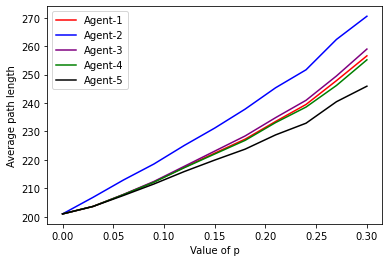

In [86]:
plt.plot(p_list,average_path_length_agent3, color = 'red')
plt.plot(p_list, average_path_length_blind_agent, color = 'blue')
plt.plot(p_list,average_path_length_normal_agent, color = 'purple')
plt.plot(p_list,average_path_length_agent4, color = 'green')
plt.plot(p_list,average_path_length_agent5, color = 'black')
plt.plot()
plt.xlabel('Value of p')
plt.ylabel('Average path length')
plt.legend(['Agent-1', 'Agent-2', 'Agent-3', 'Agent-4', 'Agent-5'])

Text(0, 0.5, 'Difference in path length')

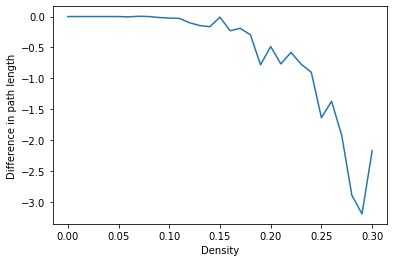

In [43]:
temp = []
for i in range(len(average_path_length_agent3)):
    temp.append(average_path_length_agent3[i] - average_path_length_normal_agent[i]) 
plt.plot(p_list, temp)
plt.xlabel('Density')
plt.ylabel('Difference in path length')

#### Nodes disc in final disc gridworld

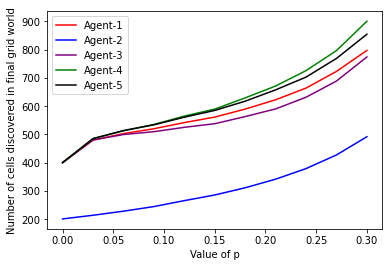

In [91]:
plt.plot(p_list,average_nodes_disc_normal_agent, color='red')
plt.plot(p_list, average_nodes_disc_blind_agent, color = 'blue')
plt.plot(p_list,average_nodes_disc_agent3, color = 'purple')
plt.plot(p_list,average_nodes_disc_agent4, color = 'green')
plt.plot(p_list,average_nodes_disc_agent5, color = 'black')
plt.xlabel('Value of p')
plt.ylabel('Number of cells discovered in final grid world')
plt.legend(['Agent-1', 'Agent-2', 'Agent-3', 'Agent-4', 'Agent-5'])

#### Planning Time

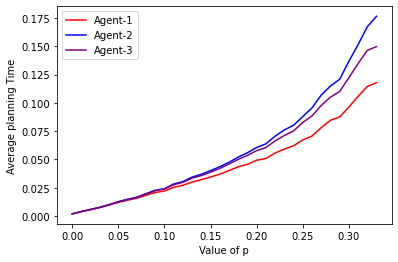

In [44]:
plt.plot(p_list,average_planning_time_normal_agent, color = 'red')
plt.plot(p_list, average_planning_time_blind_agent, color = 'blue')
plt.plot(p_list,average_planning_time_agent3, color = 'purple')
plt.plot(p_list,average_planning_time_agent4, color = 'green')
plt.plot(p_list,average_planning_time_agent5, color = 'black')
plt.xlabel('Value of p')
plt.ylabel('Average planning Time')
plt.legend(['Agent-1', 'Agent-2', 'Agent-3', 'Agent-4', 'Agent-5'])

#### Trajectory length

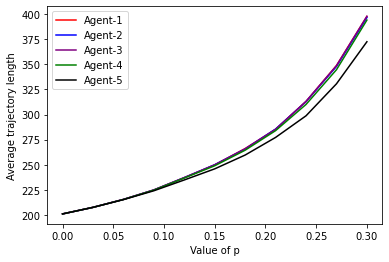

In [90]:
plt.plot(p_list,avg_trajectory_length_normal_agent, color = 'red')
plt.plot(p_list, avg_trajectory_length_blind_agent, color = 'blue')
plt.plot(p_list,avg_trajectory_length_agent3, color = 'purple')
plt.plot(p_list,avg_trajectory_length_agent4, color = 'green')
plt.plot(p_list,avg_trajectory_length_agent5, color = 'black')
plt.xlabel('Value of p')
plt.ylabel('Average trajectory length')
plt.legend(['Agent-1', 'Agent-2', 'Agent-3', 'Agent-4', 'Agent-5'])

In [55]:
traj_diff = []
for i in range(len(avg_trajectory_length_agent3)):
    traj_diff.append(avg_trajectory_length_normal_agent[i] - avg_trajectory_length_agent3[i])

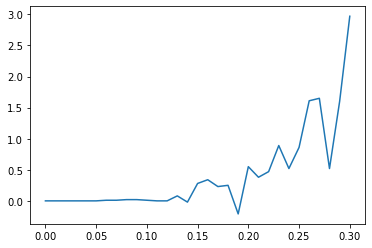

In [56]:
plt.plot(p_list, traj_diff)

In [52]:
traj_diff = []
for i in range(len(avg_trajectory_length_agent3)):
    traj_diff.append(avg_trajectory_length_normal_agent[i] - avg_trajectory_length_agent4[i])

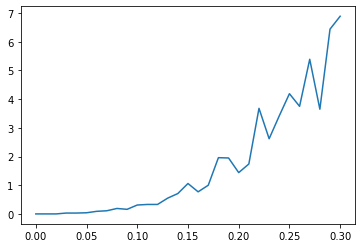

In [53]:
plt.plot(p_list, traj_diff)

#### Average cells processed

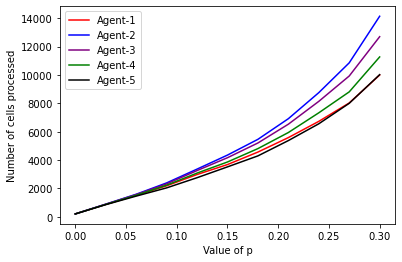

In [92]:
plt.plot(p_list,avg_cell_processed_normal_agent, color = 'red')
plt.plot(p_list, avg_cell_processed_blind_agent, color = 'blue')
plt.plot(p_list,avg_cell_processed_agent3, color = 'purple')
plt.plot(p_list,avg_cell_processed_agent4, color = 'green')
plt.plot(p_list,avg_cell_processed_agent5, color = 'black')
plt.xlabel('Value of p')
plt.ylabel('Number of cells processed')
plt.legend(['Agent-1', 'Agent-2', 'Agent-3', 'Agent-4', 'Agent-5'])

#### Average Bumps

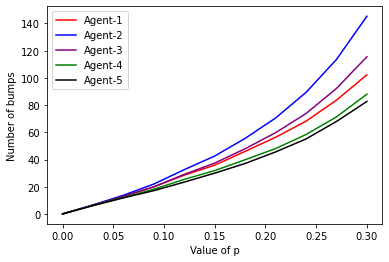

In [93]:
plt.plot(p_list,average_bumps_normal_agent, color = 'red')
plt.plot(p_list, average_bumps_blind_agent, color = 'blue')
plt.plot(p_list,average_bumps_agent3, color = 'purple')
plt.plot(p_list,average_bumps_agent4, color = 'green')
plt.plot(p_list,average_bumps_agent5, color = 'black')
plt.xlabel('Value of p')
plt.ylabel('Number of bumps')
plt.legend(['Agent-1', 'Agent-2', 'Agent-3', 'Agent-4', 'Agent-5'])

#### Average Time taken

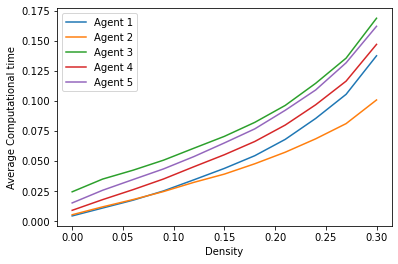

In [79]:
plt.plot(p_list,average_time_normal_agent, color = '')
plt.plot(p_list, average_time_blind_agent, color = '')
plt.plot(p_list,average_time_agent_3, color = '')
plt.plot(p_list,average_time_agent_4, color = '')
plt.plot(p_list,average_time_agent_5, color = '')
plt.xlabel('Density')
plt.ylabel('Average Computational time')
plt.legend(['Agent 1', 'Agent 2', 'Agent 3', 'Agent 4', 'Agent 5'])

#### Ratio of shortest path in dg to shortest path in cg

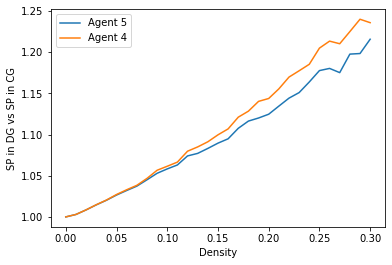

In [35]:
plt.plot(p_list,average_sp_dg_sp_cg_normal_agent)
plt.plot(p_list,average_sp_dg_sp_cg_blind_agent)
plt.plot(p_list,average_sp_dg_sp_cg_agent3)
plt.plot(p_list,average_sp_dg_sp_cg_agent4)
plt.xlabel('Density')
plt.ylabel('SP in DG vs SP in CG')
plt.legend(['Agent 5', 'Agent 4'])#, 'Agent 4'])

#### Trajectory vs SP in DG

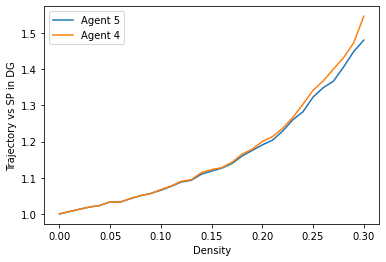

In [36]:
plt.plot(p_list,average_trajectory_sp_dg_normal_agent)
plt.plot(p_list,average_trajectory_sp_dg_blind_agent)
plt.plot(p_list,average_trajectory_sp_dg_agent3)
plt.plot(p_list,average_trajectory_sp_dg_agent4)
plt.xlabel('Density')
plt.ylabel('Trajectory vs SP in DG')
plt.legend(['Agent 5', 'Agent 4'])#, 'Agent 4'])

In [59]:
traj_diff = []
for i in range(len(avg_trajectory_length_agent3)):
    traj_diff.append(average_trajectory_sp_dg_agent3[i] - average_trajectory_sp_dg_agent4[i])

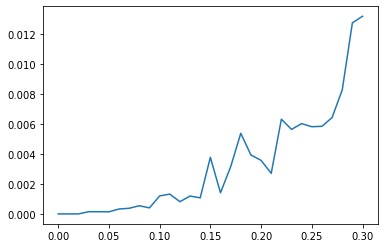

In [60]:
plt.plot(p_list, traj_diff)

In [61]:
traj_diff = []
for i in range(len(avg_trajectory_length_agent3)):
    traj_diff.append(average_trajectory_sp_dg_normal_agent[i] - average_trajectory_sp_dg_agent4[i])

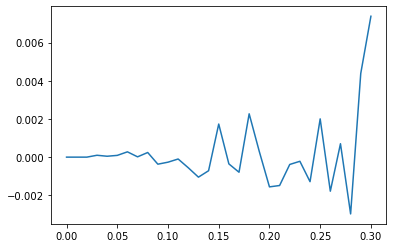

In [62]:
plt.plot(p_list, traj_diff)

### ------------------------------------------------------------------------------------------------------------------------------

In [29]:
print([[{(0,1), (1,0), (1,1)}, 1], [{(2,1), (2,2), (2,3)}, 2], [{(7,5), (6,4), (6,6)}, 1]])

[[{(0, 1), (1, 0), (1, 1)}, 1], [{(2, 3), (2, 1), (2, 2)}, 2], [{(6, 6), (7, 5), (6, 4)}, 1]]
